## On CIFAR10 Gray Data

#### Autoencoders 
#### Kirty Vedula

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.utils import np_utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap
from sklearn import svm

C:\Users\kpvedula\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def deep_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2):
    # input dimension = 1024
    input_dim = x_train.shape[1]
    
    compression_factor = float(input_dim) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    autoencoder = Sequential()

    # Encoder Layers
    autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
    autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
    autoencoder.add(Dense(encoding_dim, activation='relu'))

    # Decoder Layers
    autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
    autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))

    autoencoder.summary()

    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
    encoder_layer2 = autoencoder.layers[1]
    encoder_layer3 = autoencoder.layers[2]
    encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

    encoder.summary()
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(x_test, x_test))
    return encoder, autoencoder

In [3]:
def conv_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2):

    x_train = x_train.reshape((len(x_train), 32, 32, 1))
    x_test = x_test.reshape((len(x_test), 32, 32, 1))

    autoencoder = Sequential()

    # Encoder Layers
    autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

    # Flatten encoding for visualization
    autoencoder.add(Flatten())
    autoencoder.add(Reshape((4, 4, 8)))

    # Decoder Layers
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    autoencoder.summary()


    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
    encoder.summary()


    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(x_train, x_train,
                    epochs=70,
                    batch_size=128,
                    validation_data=(x_test, x_test))
    return encoder, autoencoder

In [4]:
def simple_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2):
    # input dimension = 1024
    input_dim = x_train.shape[1]
    
    compression_factor = float(input_dim) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    autoencoder = Sequential()
    autoencoder.add(
        Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
    )
    autoencoder.add(
        Dense(input_dim, activation='sigmoid')
    )

    autoencoder.summary()
    input_img = Input(shape=(input_dim,))
    encoder_layer = autoencoder.layers[0]
    encoder = Model(input_img, encoder_layer(input_img))

    encoder.summary()
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    return encoder, autoencoder

In [5]:
def plot_figs(x_test, y_test, encoded_imgs, decoded_imgs, ec_dim_1, ec_dim_2, labels):
    y_test = np.squeeze(y_test)
    num_images = 10
    np.random.seed(42)
    random_test_images = np.random.randint(x_test.shape[0], size=num_images)
#     print(enumerate(random_test_images))
    plt.figure(figsize=(18, 4))
#     labels = np.append(y_test[image_idx in enumerate(random_test_images)])
    
    for i, image_idx in enumerate(random_test_images):
        # plot original image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(x_test[image_idx].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot encoded image
        ax = plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(encoded_imgs[image_idx].reshape(ec_dim_1, ec_dim_2))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot reconstructed image
        ax = plt.subplot(3, num_images, 2*num_images + i + 1)
        plt.imshow(decoded_imgs[image_idx].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
    
    encoded_df = pd.DataFrame(simple_encoded_imgs)
#     print(encoded_df)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(encoded_df[0], encoded_df[1], encoded_df[2],c=y_test, cmap=plt.cm.Spectral)
    plt.show()

In [6]:
def convert_grayscale_to_fourier(data, dtype='float32'):
    fourier_images = np.zeros([data.shape[0],data.shape[1],data.shape[2]])
    for i in range(data.shape[0]):
        data[i,:,:] = np.squeeze(data[i,:,:])
        fourier_images[i,:,:] = np.fft.fft2(data[i,:,:])
        fourier_images[i,:,:] = np.fft.fftshift(fourier_images[i,:])
        fourier_images[i,:,:] = np.abs(fourier_images[i,:,:])
    return fourier_images

In [7]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.21, dtype=dtype), np.asarray(.72, dtype=dtype), np.asarray(.07, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
#     rst = np.expand_dims(rst, axis=3)
    return rst

In [8]:
# Loads the training and test data sets (ignoring class labels)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_images = 10
np.random.seed(42)
test_indices = []

nb_classes = 10
class_names = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck',}

random_test_images = np.random.randint(x_test.shape[0], size=num_images)
for index, value in enumerate(random_test_images):
    test_indices.append(value)
test_labels = y_test[test_indices]

In [9]:
x_gray_train = grayscale(x_train)
x_gray_test = grayscale(x_test)
x_gray_train = np.expand_dims(x_gray_train, axis=3)
x_gray_test = np.expand_dims(x_gray_test, axis=3)

x_train = x_gray_train
x_test = x_gray_test

In [10]:
# x_fourier_train = convert_grayscale_to_fourier(grayscale(x_train))
# x_fourier_test = convert_grayscale_to_fourier(grayscale(x_test))

# x_train = x_fourier_train
# x_test = x_fourier_test

In [11]:
# now we have only one channel in the images
img_channels = 1

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

# Reshape the 3D arrays as matrices. In doing so, we'll reshape the 28 x 28 images into vectors of length 784

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((50000, 1024), (10000, 1024))

In [12]:
encoding_dim = 64 
ec_dim_1 = 8
ec_dim_2 = 8

In [13]:
simple_encoder, simple_autoencoder = simple_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2)

Compression factor: 16.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              66560     
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
Total params: 65,600
Trainable params: 65,600
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000

In [14]:
simple_encoded_imgs = simple_encoder.predict(x_test)
simple_decoded_imgs = simple_autoencoder.predict(x_test)

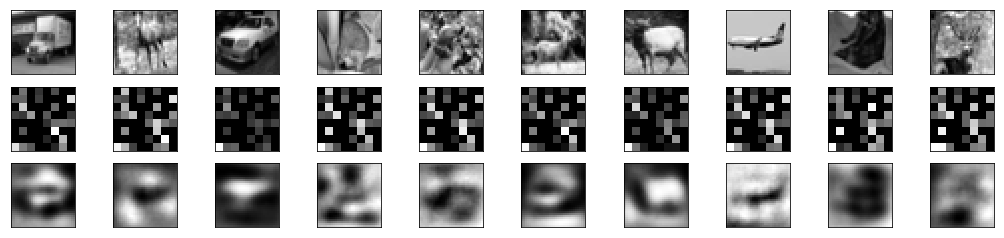

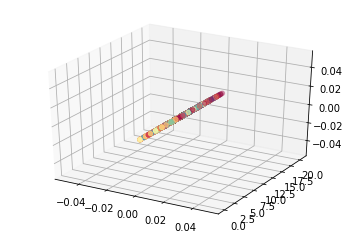

In [15]:
plot_figs(x_test, y_test, simple_encoded_imgs, simple_decoded_imgs,ec_dim_1, ec_dim_2, test_labels)

In [16]:
deep_encoder, deep_autoencoder = deep_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2)

Compression factor: 16.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              263168    
Total params: 608,064
Trainable params: 608,064
Non-trainable params: 0
_____________________________________________

In [17]:
deep_encoded_imgs = deep_encoder.predict(x_test)
deep_decoded_imgs = deep_autoencoder.predict(x_test)

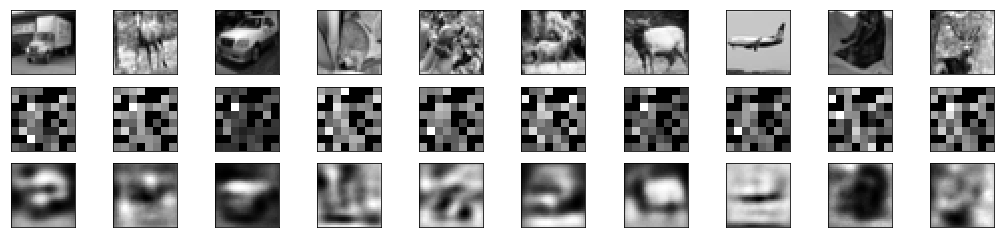

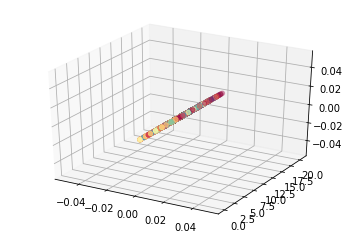

In [18]:
plot_figs(x_test,y_test, deep_encoded_imgs, deep_decoded_imgs, ec_dim_1, ec_dim_2, test_labels)

In [19]:
conv_encoder, conv_autoencoder = simple_autoencoder_CIFAR(x_train, x_test, encoding_dim, ec_dim_1, ec_dim_2)

Compression factor: 16.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              66560     
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                65600     
Total params: 65,600
Trainable params: 65,600
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000

In [20]:
conv_encoded_imgs = conv_encoder.predict(x_test)
conv_decoded_imgs = conv_autoencoder.predict(x_test)

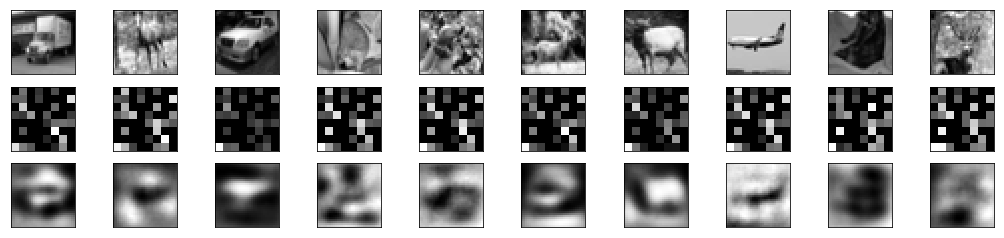

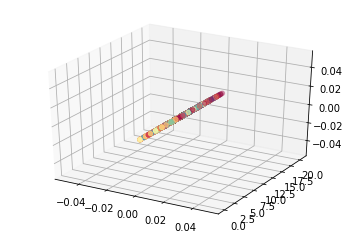

In [21]:
plot_figs(x_test,y_test, conv_encoded_imgs, conv_decoded_imgs, ec_dim_1, ec_dim_2, test_labels)

In [22]:


def train_test(data,labels):    
    from sklearn.model_selection import train_test_split 
    df_2 = pd.DataFrame(data)
    X = df_2
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
    
    return(X_train, X_test, y_train, y_test)

def kNN_classifier(x_train, y_train, x_test, y_test):
    # training a KNN classifier 
    from sklearn.neighbors import KNeighborsClassifier 
    knn = KNeighborsClassifier(n_neighbors = 10).fit(x_train, y_train) 

    # accuracy on X_test 
    accuracy = knn.score(x_test, y_test) 

    # creating a confusion matrix 
    knn_predictions = knn.predict(x_test)  
    cm = confusion_matrix(y_test, knn_predictions)
    return cm, accuracy

def SVM_classifier(x_train, y_train, x_test, y_test):
    from sklearn.svm import SVC 
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train) 
    svm_predictions = svm_model_linear.predict(x_test) 

    # model accuracy for X_test   
    accuracy = svm_model_linear.score(x_test, y_test) 

    # creating a confusion matrix 
    cm = confusion_matrix(y_test, svm_predictions) 
    return cm, accuracy
 

In [23]:
    
x_train_enc, x_test_enc, y_train_enc, y_test_enc = train_test(deep_encoded_imgs , y_test)

cm_kNN, accuracy_kNN = kNN_classifier(x_train_enc, y_train_enc, x_test_enc, y_test_enc)
cm_SVM, accuracy_SVM = SVM_classifier(x_train_enc, y_train_enc, x_test_enc, y_test_enc)

print(cm_kNN)
print(accuracy_kNN) 
print(cm_SVM)
print(accuracy_SVM)

C:\Users\kpvedula\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
C:\Users\kpvedula\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[100   3  31   3  19   2  15   4  33   2]
 [ 38  45  28  10  31   3  43   3  55   7]
 [ 74   2  90   9  25   6  26   2   7   1]
 [ 50   6  52  29  33  16  50   6   7   4]
 [ 60   2  66   7  75   3  33   4  16   1]
 [ 33   2  40  26  39  46  36   6  11   3]
 [ 36   2  57   6  45   9  85   2  13   0]
 [ 45   5  42   6  46   9  33  49  12   4]
 [ 55   7  25   5  19   3   7   5 127   3]
 [ 39  20  29  12  26   3  25   8  44  53]]
0.2796
[[ 72  14  23  14  16   4  20  13  26  10]
 [ 18  93  10  17  11   3  23  13  28  47]
 [ 48  15  52  17  29   9  37  20  11   4]
 [ 21  14  20  48  28  21  53  22  12  14]
 [ 24  12  41  18  72  18  42  23  12   5]
 [ 18  13  28  34  26  39  29  23  21  11]
 [ 17  29  13  14  26   6 107  18  13  12]
 [ 21  10  29  32  25  14  28  68  12  12]
 [ 28  19  16   6   5  11  11  25 112  23]
 [ 13  61  12   5  13   4  15  12  28  96]]
0.3036


In [ ]:
cm_kNN, accuracy_kNN = kNN_classifier(x_train, y_train, x_test, y_test)
cm_SVM, accuracy_SVM = SVM_classifier(x_train, y_train, x_test, y_test)

print(cm_kNN)
print(accuracy_kNN) 
print(cm_SVM)
print(accuracy_SVM)

C:\Users\kpvedula\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
